Predicting: 100%|██████████| 10/10 [00:00<00:00, 23.12it/s]


Mean KL Divergence: 0.0001
Median KL Divergence: 0.0000
Max KL Divergence: 0.0002
Min KL Divergence: 0.0000


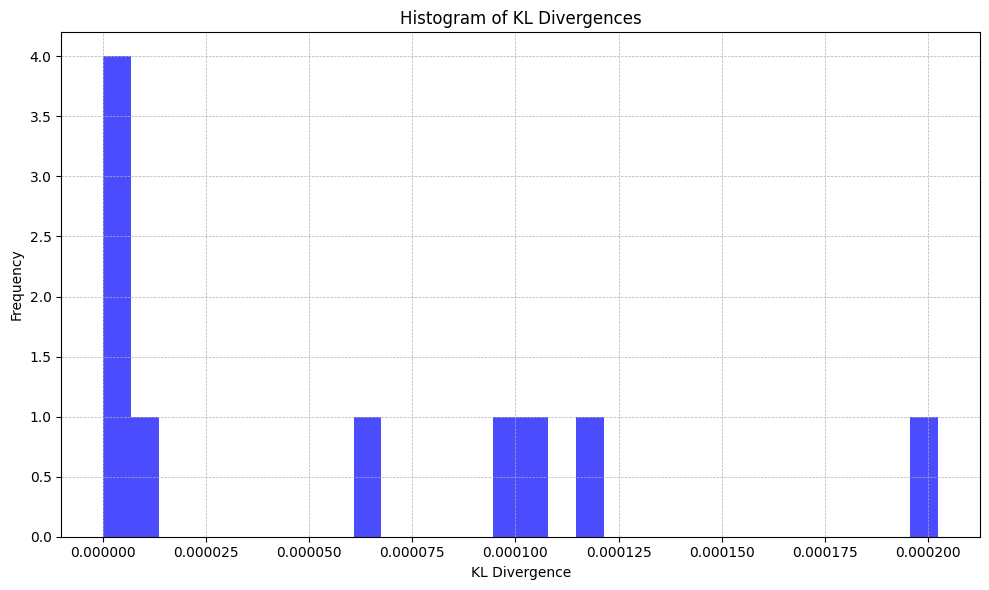

KL divergences saved to kl_divergence_values.txt
Histogram saved to kl_divergences_histogram.png


In [5]:
from tqdm import tqdm
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
import json
import torch
from tqdm import tqdm
from transformers import ViTForImageClassification
from scipy.stats import entropy
from pathlib import Path
from scipy.special import kl_div as scipy_kl_div
from scipy.special import softmax
import matplotlib.pyplot as plt

# Constants
current_dir = "/home/workstation/code/XAImethods/CAIN"
dataset_path = f"{current_dir}/evaluation_results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM/"

# Helper Functions
def ensure_rgb(img):
    """Ensure the image is in RGB format."""
    return img.convert('RGB') if img.mode != 'RGB' else img

def compute_kl_divergence(p, q):
    """Compute KL Divergence between two distributions p and q."""
    prob1 = softmax(p)
    prob2 = softmax(q)
    
    kl_div_value = scipy_kl_div(prob1, prob2).sum()
    normalized_kl_div = kl_div_value / np.log(len(p))
    return normalized_kl_div

def load_subdirs(dataset_path):
    """Load subdirectories from a given path."""
    dataset_path = Path(dataset_path)
    return [subdir for subdir in dataset_path.iterdir() if subdir.is_dir()]

def load_images_from_subdirs(root_path):
    """Load original and masked images from subdirectories."""
    dataset = []
    for subdir in os.listdir(root_path):
        subdir_path = os.path.join(root_path, subdir)
        if os.path.isdir(subdir_path):
            original_image_path = os.path.join(subdir_path, "original.jpg")
            masked_image_path = os.path.join(subdir_path, "masked_image.jpg")
            if os.path.exists(original_image_path) and os.path.exists(masked_image_path):
                dataset.append((original_image_path, masked_image_path))
    return dataset

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction & KL Divergence Calculation
dataset = load_images_from_subdirs(dataset_path)
original_scores, masked_scores = [], []

for original_path, masked_path in tqdm(dataset, desc="Predicting"):
    original_img, masked_img = map(ensure_rgb, [Image.open(original_path), Image.open(masked_path)])
    original_tensor, masked_tensor = map(lambda img: transform(img).to(device).unsqueeze(0), [original_img, masked_img])
    
    with torch.no_grad():
        original_probs = torch.nn.functional.softmax(model(original_tensor).logits, dim=1).cpu().numpy().flatten()
        masked_probs = torch.nn.functional.softmax(model(masked_tensor).logits, dim=1).cpu().numpy().flatten()

    original_scores.append(original_probs)
    masked_scores.append(masked_probs)



kl_divergences = [compute_kl_divergence(orig, mask) for orig, mask in zip(original_scores, masked_scores)]

# Compute KL Divergence Statistics
mean_kl = np.mean(kl_divergences)
median_kl = np.median(kl_divergences)
max_kl = np.max(kl_divergences)
min_kl = np.min(kl_divergences)

print(f"Mean KL Divergence: {mean_kl:.4f}")
print(f"Median KL Divergence: {median_kl:.4f}")
print(f"Max KL Divergence: {max_kl:.4f}")
print(f"Min KL Divergence: {min_kl:.4f}")

# Save KL Divergence Values
with open("kl_divergence_values.txt", 'w') as outfile:
    for kl in kl_divergences:
        outfile.write(f"{kl:.4f}\n")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(kl_divergences, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of KL Divergences")
plt.xlabel("KL Divergence")
plt.ylabel("Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the histogram
plt.savefig("kl_divergences_histogram.png", dpi=300)
plt.show()

print(f"KL divergences saved to kl_divergence_values.txt")
print(f"Histogram saved to kl_divergences_histogram.png")


In [ ]:
# # ... [Skipping some imports to avoid redundancy]

# from transformers import ViTForImageClassification, CvtForImageClassification

# # Constants
# current_dir = "/home/workstation/code/XAImethods/CAIN"
# dataset_path = f"{current_dir}/evaluation_results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM/"

# # Helper Functions [No Changes Here]

# # Model Initialization
# # Comment out or delete the ViT model initialization if you want to only use CvT
# # model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)
# model = CvtForImageClassification.from_pretrained('microsoft/cvt-13').to(device)  # Use this for CvT
# model.eval()

# # Adjust image size transformation based on the model
# # transform = transforms.Compose([
# #     transforms.Resize((384, 384)), # Adjust size for ViT
# #     transforms.ToTensor(),
# #     normalize
# # ])
# transform = transforms.Compose([
#     transforms.Resize((480, 640)),  # Adjust size for CvT
#     transforms.ToTensor(),
#     normalize
# ])

# # Prediction & KL Divergence Calculation [No Changes Here]
# # ... 

# # Save KL Divergence Values [No Changes Here]
# # ...
